# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Introduction:-Genetic-Analysis-Using-Global-Expression-Measurements" data-toc-modified-id="Introduction:-Genetic-Analysis-Using-Global-Expression-Measurements-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Introduction: Genetic Analysis Using Global Expression Measurements</a></div><div class="lev1 toc-item"><a href="#Number-of-Coexpressed-and-Antiexpressed-Genes" data-toc-modified-id="Number-of-Coexpressed-and-Antiexpressed-Genes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Number of Coexpressed and Antiexpressed Genes</a></div><div class="lev2 toc-item"><a href="#Figure-4.-Weighted-Correlations-Reflect-Functional-Distance" data-toc-modified-id="Figure-4.-Weighted-Correlations-Reflect-Functional-Distance-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Figure 4. Weighted Correlations Reflect Functional Distance</a></div><div class="lev2 toc-item"><a href="#hif-1-has-negative-interactions-with-rhy-1,-and-egl-9" data-toc-modified-id="hif-1-has-negative-interactions-with-rhy-1,-and-egl-9-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span><em>hif-1</em> has negative interactions with <em>rhy-1</em>, and <em>egl-9</em></a></div><div class="lev1 toc-item"><a href="#Quality-Control" data-toc-modified-id="Quality-Control-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Quality Control</a></div><div class="lev2 toc-item"><a href="#Quality-control-on-identified-genes:" data-toc-modified-id="Quality-control-on-identified-genes:-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Quality control on identified genes:</a></div><div class="lev1 toc-item"><a href="#Identifying-New-Biology---understanding-the-role-of-rhy-1-and-egl-9-in-the-hif-1-dependent-response" data-toc-modified-id="Identifying-New-Biology---understanding-the-role-of-rhy-1-and-egl-9-in-the-hif-1-dependent-response-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Identifying New Biology - understanding the role of <em>rhy-1</em> and <em>egl-9</em> in the <em>hif-1</em> dependent response</a></div><div class="lev2 toc-item"><a href="#Genes-that-go-down-in-all-hypoxia-mutants" data-toc-modified-id="Genes-that-go-down-in-all-hypoxia-mutants-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Genes that go down in all hypoxia mutants</a></div><div class="lev2 toc-item"><a href="#Genes-up-in-all-hypoxia-mutants" data-toc-modified-id="Genes-up-in-all-hypoxia-mutants-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Genes up in all hypoxia mutants</a></div><div class="lev1 toc-item"><a href="#Bokeh-Epistasis-Plots" data-toc-modified-id="Bokeh-Epistasis-Plots-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Bokeh Epistasis Plots</a></div><div class="lev2 toc-item"><a href="#Overlap-between-just-two-things" data-toc-modified-id="Overlap-between-just-two-things-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Overlap between just two things</a></div><div class="lev2 toc-item"><a href="#Identifying-all-genes-associated-with-the-hypoxia-response" data-toc-modified-id="Identifying-all-genes-associated-with-the-hypoxia-response-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Identifying all genes associated with the hypoxia response</a></div><div class="lev1 toc-item"><a href="#Single-Mutant-Comparison-Interactive-Plots" data-toc-modified-id="Single-Mutant-Comparison-Interactive-Plots-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Single Mutant Comparison Interactive Plots</a></div>

# Introduction: Genetic Analysis Using Global Expression Measurements

The following sections will provide (excruciating) detail on how we performed the genetic analysis of our mutants using this data. Initially, this analysis was done blindly. For clarity, I have added all the genotype identifiers from the beginning.

To start, we should load all the python libraries that we will need:

In [2]:
# important stuff:
import os
import pandas as pd
import numpy as np
from IPython.core.display import HTML

# stats
import sklearn.decomposition
from scipy import stats as sts
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster import hierarchy
import statsmodels.api as stm

# TEA and morgan
import tissue_enrichment_analysis as tea
import morgan as morgan

# network graphics
import networkx as nx

# Graphics
import matplotlib as mpl
import matplotlib.ticker as plticker
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as path_effects
from matplotlib import rc
rc('text', usetex=True)

# bokeh
import bokeh.charts
import bokeh.charts.utils
import bokeh.io
import bokeh.models
import bokeh.palettes
import bokeh.plotting
from bokeh.plotting import figure
from bokeh.resources import CDN
from bokeh.embed import file_html


# bayes and mcmc
import pymc3 as pm
import theano

# Display graphics in this notebook
bokeh.io.output_notebook()

# Magic function to make matplotlib inline;
# other style specs must come AFTER
%matplotlib inline

# This enables SVG graphics inline. 
# There is a bug, so uncomment if it works.
%config InlineBackend.figure_formats = {'png', 'retina'}

# JB's favorite Seaborn settings for notebooks
rc = {'lines.linewidth': 2, 
      'axes.labelsize': 18, 
      'axes.titlesize': 18, 
      'axes.facecolor': 'DFDFE5'}
sns.set_context('notebook', rc=rc)
sns.set_style("dark")

ft = 35 #title fontsize
import genpy

Loading BokehJS ...

Next, I need to load the **phenotype_df** (please don't use this file without permission for publication purposes. This tool is unpublished [I am actively working on a paper with this] and will be available soon. I provide it here for clarity, even though it was not part of our paper), the **tissue_df** and the **tf_df**. These files contains a phenotype-gene dictionary, a tissue-gene dictionary (downloaded from TEA) and a transcription factor list (from Chris Grove). 

Additionally, I will initialize several variables whose purpose will mainly be to prettify the tables and substitute in the correct names. 

In [3]:
fname = '../input/dictionaries/phenotype_dictionary.csv'
phenotype_df = pd.read_csv(fname)
fname = '../input/dictionaries/go_dictionary.csv'
go_df = pd.read_csv(fname)
tissue_df = tea.fetch_dictionary()
tf_df = pd.read_csv('../input/tf_list.csv')
hypoxia_gold = pd.read_csv('../input/hypoxia_gold_standard.csv',
                           sep=',')

genotype_mapping = {'a': r'\emph{egl-9;vhl-1}',
                    'f': r'\emph{egl-9;hif-1}',
                    'b': r'\emph{egl-9}',
                    'c': r'\emph{hif-1}',
                    'd': r'\emph{vhl-1}',
                    'e': r'\emph{rhy-1}',
                    'g': r'\emph{fog-2}'
                    }

sort_pairs = {'eb': 1, 'be': 1,
              'ed': 2,'de': 2,
              'ec': 3,'ce': 3,
              'eg': 4,'ge': 4,
              'bd': 5,'db': 5,
              'cb': 6,'bc': 6,
              'bg': 7, 'gb': 7,
              'cd': 8,'dc': 8,
              'dg': 9,'gd': 9,
              'cg': 10,'gc': 10
             }

decode_pairs = {'eb': '\emph{rhy-1}, \emph{egl-9}',
                'be': '\emph{rhy-1}, \emph{egl-9}',
                'ed': '\emph{rhy-1}, \emph{vhl-1}',
                'de': '\emph{rhy-1}, \emph{vhl-1}',
                'ec': '\emph{rhy-1}, \emph{hif-1}',
                'ce': '\emph{rhy-1}, \emph{hif-1}',
                'eg': '\emph{rhy-1}, \emph{fog-2}',
                'ge': '\emph{rhy-1}, \emph{fog-2}',
                'bd': '\emph{egl-9}, \emph{vhl-1}',
                'db': '\emph{egl-9}, \emph{vhl-1}',
                'cb': '\emph{egl-9}, \emph{hif-1}',
                'bc': '\emph{egl-9}, \emph{hif-1}',
                'bg': '\emph{egl-9}, \emph{fog-2}',
                'gb': '\emph{egl-9}, \emph{fog-2}',
                'cd': '\emph{vhl-1}, \emph{hif-1}',
                'dc': '\emph{vhl-1}, \emph{hif-1}',
                'dg': '\emph{vhl-1}, \emph{fog-2}',
                'gd': '\emph{vhl-1}, \emph{fog-2}',
                'cg': '\emph{hif-1}, \emph{fog-2}',
                'gc': '\emph{hif-1}, \emph{fog-2}'
               }

Next, we will load up all of our files. These files will be placed within a class called morgan.hunt (funny!). All of the classes that are referenced in this tutorial are in the file morgan.py, which you are welcome to use for your own analysis. The classes are relatively well-documented and should be usable if you are careful. That said, I am not a computer scientist, so some pathologies or bugs may pop up -- if they do, please perform a pull-request on our github with a fix for the bug. Alternatively, please email me a sufficiently detailed script so I can reconstruct the failure event and correct the bug.

In [4]:
# Specify the genotypes to refer to:
single_mutants = ['b', 'c', 'd', 'e', 'g']
# Specify which genotypes are double mutants 
# and of what single mutants:
double_mutants = {'a' : 'bd', 'f':'bc'}

# initialize the morgan.hunt object:
# target_id is the column with isoform specific names
# b is the name of the column with the GLM regression coefficients
# tpm is the name of the column with the TPM numbers
# qval is the name of the column with the FDR corrected q-values
thomas = morgan.hunt('target_id', 'b', 'tpm', 'qval')

# input the genmap file:
thomas.add_genmap('../input/library_genotype_mapping.txt', comment='#')

# add the names of the single mutants
thomas.add_single_mutant(single_mutants)

# add the names of the double mutants
thomas.add_double_mutants(['a', 'f'], ['bd', 'bc'])

# set the q-value threshold for significance to its default value, 0.1
thomas.set_qval()

# Add the tpm files: 
kallisto_loc = '../input/kallisto_all/'
thomas.add_tpm(kallisto_loc, '/kallisto/abundance.tsv', '')

# Make all possible combinations of WT, X
combs = {}
for gene in thomas.genmap.genotype.unique():
    if gene != 'wt':
        combs[gene] = 'WT_'+gene+'/'

# # load all the beta values for each genotype:
# sleuth_loc = '../sleuth/'
# thomas.add_betas(sleuth_loc, 'betas.csv', combs)

# load all the beta values for each genotype:
sleuth_loc = '../sleuth_all_adjusted/kallisto/'
for file in os.listdir("../sleuth_all_adjusted/kallisto"):
    if file[:4] == 'beta':
        letter = file[-5:-4].lower()
        thomas.add_beta(sleuth_loc + file, letter)
        thomas.beta[letter].sort_values('target_id', inplace=True)
        thomas.beta[letter].reset_index(inplace=True)


Next, I will filter the data, removing any genes that don't show up in all the files and removing the bottom 10% of the genes by expression level. This is an aggressive cutoff, I know. 

In [5]:
thomas.filter_data(0, 0.1)

Number of na genes: 232


# Number of Coexpressed and Antiexpressed Genes

In [ ]:
def tidy_df(df, corr='corr', morgan_obj=thomas):
    """
    A function that returns a tidied up dataframe.
    
    Dataframe provided must be the result of morgan.robust_regression()
    or morgan.robust_regression_secondary()
    
    df - dataframe to tidy up
    corr - a string indicating whether to use 'corr' or 'outliers'
    
    outputs:
    df - a tidied dataframe with columns 'corr_wit', 'variable',
        'fraction' and 'pair'
    """
    # make a copy of the df
    df = df.copy()
    # append a column called corr_with
    if 'corr_with' not in df:
        df['corr_with'] = morgan_obj.single_mutants
    # melt it so that each row has a single correlation
    df = pd.melt(df, id_vars='corr_with')
    # drop any observations where the correlated letters are the same
    df = df[df.corr_with != df.variable]

    def calculate_fraction(x, fraction='corr'):
        """Fraction of genes that participate in a given interaction."""
        if (x.corr_with, x.variable) in barbara.correlated_genes.keys():
            dd = barbara.correlated_genes[(x.corr_with, x.variable)]
            outliers = len(dd['outliers'])
            corr = len(dd['corr'])
            total = outliers + corr
            if fraction == 'corr':
                return corr/total
            else:
                return outliers/total
        else:
            return np.nan
    
    # calculate the fraction of genes participating in any interaction 
    df['fraction'] = df.apply(calculate_fraction, args=(corr,), axis=1)
    # generate a new variable 'pair' that is 
    # the sum of the correlated genotypes (i.e. 'a', 'b' --> 'ab')
    df['pair'] =  df.variable + df.corr_with
    # return the damned thing:
    return df

def different(x, d):
    """
    Returns an indicator variable if the primary regression
    is different in sign from the secondary.
    """
    # extract the pair in question:
    p = x.pair
    # search for the primary interaction in the dataframe
    primary = d[(d.pair == p) & 
                (d.regression == 'primary')].value.values[0]
    # search for the secondary
    secondary = d[(d.pair == p) & 
                  (d.regression == 'secondary')].value.values[0]
    
    # if the interactions are 0, return 0
    if primary == 0 or secondary == 0:
        return 0
    # if they have the same sign, return -1
    elif (primary*secondary > 0):
        return -1
    # otherwise return 1
    else:
        return 1

def special_add(x):
    """
    If the primary and secondary have the same sign,
    returns the addition of both.
    """
    # if the current row is a secondary row
    # and the primary and secondary rows are the same
    # then return np.nan since we will want to ignore 
    # the secondary correlation
    # if they are different in sign, return the current value
    if x.regression == 'secondary':
        if x.different == -1:
            return np.nan
        else:
            return x.value
    
    # if the regression is primary, 
    # then add the values if the correlations have the same sign
    # otherwise just return the current value:
    check = d[(d.regression=='secondary') & \
         (d.pair == x.pair)].different.values
    if check == -1:
        to_add = d[(d.regression=='secondary') & 
                   (d.pair == x.pair)].value.values[0]
        return x.value + to_add
    else:
        return x.value

# tidy up the dataframe w/bayesian primary interactions:
d_pos = tidy_df(barbara.robust_slope)
# add a label specifying these are the primary regressions
d_pos['regression'] = 'primary'
# tidy up the secondary interactions
d_minus = tidy_df(barbara.secondary_slope, corr='outliers')
# add a label specifying these are the secondary regressions
d_minus['regression'] = 'secondary'

# concatenate the dataframes
frames = [d_pos, d_minus]
d = pd.concat(frames)

# identify whether primary and secondary 
# interactions have different signs
d['different'] = d.apply(different, args=(d,), axis=1)
# drop any fractions that are NAN
d.dropna(subset=['fraction'], inplace=True)
# calculate corrected coefficients
d['corrected'] = d.apply(special_add, axis=1)
# drop any NAN corrected columns
d.dropna(subset=['corrected'], inplace=True)

# sort the pairs according to functional distance
d['sort_pairs'] = d.pair.map(sort_pairs)
d.sort('sort_pairs', inplace=True)

# add the labels for plotting:
d['genes'] = d.pair.map(decode_pairs)

In [ ]:
# extract the standard error for each correlation
e_plus = tidy_df(barbara.errors_primary)

# add a sort pairs column
e_plus['sort_pairs'] = e_plus.pair.map(sort_pairs)
# decode the gene pairs
e_plus['genes'] = e_plus.pair.map(decode_pairs)
# sort
e_plus.sort('sort_pairs', inplace=True)
# drop nonnumeric values
e_plus.dropna(inplace=True)

# repeat for secondary errors
e_minus = tidy_df(barbara.errors_secondary)
e_minus['sort_pairs'] = e_minus.pair.map(sort_pairs)
e_minus['genes'] = e_minus.pair.map(decode_pairs)
e_minus.sort('sort_pairs', inplace=True)
e_minus.dropna(inplace=True)

## Figure 4. Weighted Correlations Reflect Functional Distance

Now we can plot the weighted correlations, making sure that they are ordered by functional distance.

In [ ]:
# generate a stripplot with all the 
sns.stripplot(x='genes', y='corrected',
              data=d[d.regression=='primary'], size=15,
              color='g', alpha=0.7)

# add errorbars:
# for each xtick and xticklabel
for x, xlabel in zip(plt.gca().get_xticks(),
                     plt.gca().get_xticklabels()):
    # get the data
    temp = d[d.regression=='primary']
    # get the gene ID
    f = temp.genes == xlabel.get_text() 
    # get the error bar gene ID
    f2 = e_plus.genes == xlabel.get_text() 
    # plot the errorbar
    plt.gca().errorbar(np.ones_like(temp[f].corrected.values)*x, 
                       temp[f].corrected.values,
                       yerr=e_plus[f2].value.values,
                       ls='none', color='g')

# prettify:
plt.xticks(rotation=45, fontsize=20)
# plt.yticks([-0.1, 0, 0.5], fontsize=20)
plt.yticks(fontsize=20)
plt.axhline(0, lw=2, ls='--', color='gray')
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# pathify
pathify('Weighted Correlations Reflect Functional Distance',
        'Pairs of Genes, Ordered by Decreasing Functional Distance',
       'Primary Correlation, Normalized to Overlap')

# save
plt.savefig('../output/weighted_corr_decreases_w_distance.pdf')

## *hif-1* has negative interactions with *rhy-1*, and *egl-9*

If we look at the secondary, what picture emerges? The most striking picture is that there are two modes of interaction between *rhy-1* and *vhl-1*, *hif-1* and *fog-2*. In every case, the secondary interaction is considerably less than 10% of the total overlap. I will make the claim that these interactions are stronger and more important than we may believe at first sight, but I won't push it. We will wait until we have more datasets to show this. 

In [ ]:
# plot secondary interactions
sns.stripplot(x='genes', y='corrected', 
              data=d[(d.regression=='secondary') &
                     (d.different == 1)],
              size=10, color='k')

# add errorbars:
for x, xlabel in zip(plt.gca().get_xticks(),
                     plt.gca().get_xticklabels()):
    temp = d[d.regression=='secondary']
    f = temp.genes == xlabel.get_text() 
    f2 = e_minus.genes == xlabel.get_text() 
    plt.gca().errorbar(np.ones_like(temp[f].corrected.values)*x, 
                       temp[f].corrected.values,
                       yerr=e_minus[f2].value.values,
                       ls='none', color='k')

# prettify
plt.axhline(0, ls='--', color='0.5')
plt.xticks(rotation=45, fontsize=20)
plt.yticks([-0.1, 0, 0.1], fontsize=20)
plt.axhline(0, lw=2, ls='--', color='gray')
plt.ylabel('Secondary Correlation, Normalized to Overlap')

# Quality Control

Load up the hypoxia gold standard Carmie gave me. These genes are expected to go up in everything except in Hif-1. 

By this point, I have solved the network, I guessed which gene was Hif-1 and I have been told the identities of the genes. 

C = Hif-1  
B = egl-9  
D = vhl-1  
E = rhy-1  

nhr-57 is an important gene for hypoxia. WBID is WBGene00003647

In [7]:
# Figure out how many hits we get and if the pvalue is significant!
for sm in thomas.single_mutants:
    df = thomas.beta_filtered[sm]
    ind = (genpy.find(df, hypoxia_gold.WBIDS,
                      col='ens_gene'))
    found = df[ind & (df.qval < 0.1)]
    sig = df[df.qval < 0.1]
    pval = sts.hypergeom.sf(len(found),
                            len(df),
                            len(hypoxia_gold),
                            len(sig))
    print('genotype: ', sm)
    print('found: ', len(found), 
          '  Mean b: {0:.2g}'.format(found.b.mean()))
    print('pval: {0:.2g}'.format(pval))
    
    
    print('Maximum change was:')
    print(found[found.b == found.b.max()].ext_gene.values[0])
    print(np.exp(found[found.b == found.b.max()].b.values)[0],
          ' fold change')
    if 'WBGene00003647' in found.ens_gene.values:
        ind = found.ens_gene == 'WBGene00003647'
        nhr57 = np.exp(found[ind].b.values[0])
        print('nhr-57 is in', sm,
              'and its fold change was {0:.2g}'.format(nhr57))

    print('----------')

genotype:  d
found:  7   Mean b: 2.2
pval: 2.7e-06
Maximum change was:
dod-3
44.7574873949  fold change
nhr-57 is in d and its fold change was 7.1
----------
genotype:  b
found:  9   Mean b: 2.6
pval: 5.7e-05
Maximum change was:
oac-54
66.7297848473  fold change
nhr-57 is in b and its fold change was 63
----------
genotype:  g
found:  4   Mean b: -1.4
pval: 0.22
Maximum change was:
nhr-57
0.534489095703  fold change
nhr-57 is in g and its fold change was 0.53
----------
genotype:  e
found:  10   Mean b: 2.4
pval: 4.7e-05
Maximum change was:
nhr-57
45.6749505822  fold change
nhr-57 is in e and its fold change was 46
----------
genotype:  c
found:  1   Mean b: 0.49
pval: 0.19
Maximum change was:
rhy-1
1.62443595728  fold change
----------


## Quality control on identified genes:

Before we call these *hif-1* targets, we should make sure that at least some known targets are contained in this set. In order to do this, we have curated a list of 20 or so genes that have been published before as *hif-1* targets.

That being said though, we need to be aware of 1 major issue with this dataset. 

*hif-1* and *rhy-1* form an incredibly tight loop. There is a LOT of feedback between *hif-1* and *rhy-1*. Given the kind of logic we are using, we are probably excluding a number of targets as a result. In fact, the logic we have used to develop this list excludes *rhy-1* itself, a known *hif-1* target! I could do better, but not without a lot more lines of code, and it just doesn't seem reasonable to do this. 

In [51]:
ind = hypoxia_direct_targets.ens_gene.isin(hypoxia_gold.WBIDS)
found = hypoxia_direct_targets[ind].ens_gene.unique()
sig = len(hypoxia_direct_targets)
pval = sts.hypergeom.sf(len(found),
                        len(thomas.beta_filtered['a']),
                        len(hypoxia_gold), sig)    

if pval < 10**-3:
    print('This result is statistically significant \
with a p-value of {0:.2g} using a hypergeometric test.\
 You found {1} gold standard genes!'.format(pval, len(found)))

This result is statistically significant with a p-value of 4.2e-08 using a hypergeometric test.You found 5 gold standard genes!


# Identifying New Biology - understanding the role of *rhy-1* and *egl-9* in the *hif-1* dependent response

The extensive feedback loops suggest that there should be a subset of genes that are coexpressed in every single mutant studied here. Moreover, there should be some genes that go up in every single mutant and down in every single mutant. Because these genes are probably very tightly linked, and have been measured 6x3 times, they would constitute high-confidence genes. Studying these genes will hopefully clarify the epistasis relationships by removing noise and finding genes that are only associated with the core circuit we have selected; identify genes that are tightly linked and crucial for the stress response; and make for very nice interactive graphics.

In [37]:
ind = (
       (df1.qval >  0.1) &  # eglhif doesnt change
       (df1.q_e < 0.1) &  # rhy changes
       (df1.q_b < 0.1) &  # egl changes
       (df1.q_a < 0.1) &  # eglvhl changes
       (df1.q_d < 0.1)  #vhl changes
      )
hypoxia_response = df1[ind]
print(hypoxia_response.shape)
print(hypoxia_response[hypoxia_response.ens_gene.isin(hypoxia_gold.WBIDS)].shape)

hypoxia_response.to_csv('hypoxia_response.csv', index=False)

(274, 30)
(6, 30)


In [9]:
# select all the genes that are stat. sig. with the exception
# of the egl-9;hif-1 suppressor
ind = ((df1.q_c < 0.1) & (df1.q_e < 0.1) &
      (df1.q_b < 0.1) & (df1.q_a < 0.1) &
       (df1.q_d < 0.1))
y = df1[ind].copy()
y.shape

(55, 30)

## Genes that go down in all hypoxia mutants

In [10]:
y_bs = df1[ind][['ens_gene', 'b_e', 'b_b', 'b_d', 'b_c', 'b', 'b_a']]
all_down = y_bs[y_bs<0].dropna().index
s = 'Number of genes that go down: {0}'
message = s.format(len(all_down))
print(message)

Number of genes that go down: 13


In [11]:
cols = ['ext_gene', 'ens_gene', 
        'b_e', 'b_b', 'b_d', 'b_c', 'b_a',
        'q_e', 'q_b', 'q_d', 'q_c', 'q_a']
sel = df1.index.isin(y_bs[y_bs<0].index)
all_down = df1[sel][cols].sort_values('q_a')
all_down.to_csv('../output/all_down.csv', index=False)
ids = all_down.ens_gene.unique()
_ = tea.enrichment_analysis(ids,
                            tissue_df, show=True)
_ = tea.enrichment_analysis(ids,
                            phenotype_df, show=True)
_ = tea.enrichment_analysis(ids,
                            go_df, show=False)
_[0].head()

Executing script

Analysis returned no enriched tissues.
Executing script

                                              Tissue  Expected  Observed  \
0  postembryonic cell lineage variant WBPhenotype...  0.503514         4   
1  cell cycle timing defective early emb WBPhenot...  0.292038         3   

   Enrichment Fold Change   P value   Q value  
0                7.944167  0.000129  0.031593  
1               10.272629  0.000191  0.031593  
Executing script



,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
82,S-adenosylmethionine-dependent methyltransfera...,3.288615,21,6.385667,8.694608e-14,5.755830e-11
131,cell division GO:0051301,3.412256,21,6.154286,1.835900e-13,6.076829e-11
79,ion binding GO:0043167,1.020646,12,11.757255,1.555222e-11,3.431856e-09
13,regulatory region nucleic acid binding GO:0001067,0.548507,9,16.408191,1.530384e-10,2.532786e-08
6,organic anion transport GO:0015711,1.903712,14,7.354055,2.622568e-10,3.472279e-08


## Genes up in all hypoxia mutants

In [12]:
all_up = y_bs[y_bs>0].dropna().index
s = 'Number of genes that go up: {0}'
message = s.format(len(all_up))
print(message)

cols = ['ext_gene', 'ens_gene', 
        'b_e', 'b_b', 'b_d', 'b_c', 'b_a',
        'q_e', 'q_b', 'q_d', 'q_c', 'q_a']
all_up = df1[df1.index.isin(all_up)][cols].sort_values('q_a')
all_up.to_csv('../output/all_up.csv', index=False)
ids = all_up.ens_gene.unique()
_ = tea.enrichment_analysis(ids,
                            tissue_df, show=True)
_ = tea.enrichment_analysis(ids,
                            phenotype_df, show=True)
_ = tea.enrichment_analysis(ids,
                            go_df, show=False)
_[0].head()

Number of genes that go up: 23
Executing script

Analysis returned no enriched tissues.
Executing script

Analysis returned no enriched tissues.
Executing script



,Tissue,Expected,Observed,Enrichment Fold Change,P value,Q value
36,cellular modified amino acid metabolic process...,0.079608,4,50.246276,1.386539e-08,0.000009
72,regulation of hydrolase activity GO:0051336,0.123417,4,32.410377,1.222363e-07,0.000040
46,monovalent inorganic cation homeostasis GO:005...,0.036049,2,55.480263,6.338274e-06,0.001399
38,intracellular organelle GO:0043229,0.540482,5,9.250993,1.037927e-05,0.001718
18,protein complex binding GO:0032403,0.005507,1,181.571770,1.367406e-05,0.001810


# Bokeh Epistasis Plots

In [13]:
def bokeh_plot_epistasis(df, gx, gy, qx, qy, se_gx, se_gy,
                         tooltips, title, xlabel):
    """A function to plot the bokeh epistasis."""
    # Make the hover tool
    hover = bokeh.models.HoverTool(tooltips=tooltips,
                                   names=['circles'])

    # Create figure
    p = bokeh.plotting.figure(title=title, plot_width=650, 
                              plot_height=450)

    p.xgrid.grid_line_color = 'white'
    p.ygrid.grid_line_color = 'white'
    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = r'Delta'

    # Add the hover tool
    p.add_tools(hover)

    # Define colors in a dictionary to access them with
    # the key from the pandas groupby funciton.
    df['delta'] = df[gy] - df[gx]

    transformed_q = -df[qx].apply(np.log)
    transformed_q[transformed_q > 15] = 15
    cols = [
        "#%02x%02x%02x" % (int(r), 
        int(g), int(b)) for r, g, b, _ in
        255*mpl.cm.viridis(mpl.colors.Normalize()(
                           transformed_q))
            ]
        
    df['colors'] = cols
    
    source1 = bokeh.models.ColumnDataSource(df)

    # Specify data source
    p.circle(x=gx, y='delta', size=7,
             alpha=0.4, source=source1,
             color='colors', name='circles')
    p.circle(x=gx, y='delta', size=7,
             alpha=1, fill_color=None,
             source=source1, color='black')
    
    def bokeh_errorbars():
        # create the coordinates for the errorbars

        def zipper(which='x'):
            err_xs = []
            err_ys = []
            if which == 'x':
                for x, z, xerr in zip(df[gx],
                                      df[gy] - df[gx],
                                      df[se_gx]):
                    err_xs.append((x - xerr, x + xerr))
                    err_ys.append((z, z))
            else:

                yerr = np.sqrt(df[se_gy]**2 + df[se_gx]**2)
                for x, y, yerror in zip(df[gx],
                                     df[gy] - df[gx],
                                     yerr):
                    err_xs.append((x, x))
                    y_tuple = (y - yerror, y + yerror)
                    err_ys.append(y_tuple)

            return err_xs, err_ys
        
        errx_xs, errx_ys = zipper('x')
        erry_xs, erry_ys = zipper('y')
        
        return errx_xs, errx_ys, erry_xs, erry_ys
    
    errx_xs, errx_ys, erry_xs, erry_ys = bokeh_errorbars()
    # plot them
    p.multi_line(errx_xs, errx_ys, color=cols, alpha=0.4)
    p.multi_line(erry_xs, erry_ys, color=cols, alpha=0.4)

    p.background_fill_color = "#DFDFE5"
    p.background_fill_alpha = 0.5
    
    return p

In [14]:
def plot_significance(df, gx, gy, se_gx, se_gy, p):
    """A function to circle in red any points that have a delta > 0."""
    x = np.where(sts.norm(df[gx]-df[gy], 
                          np.sqrt(df[se_gx]**2 +
                          df[se_gy]**2)).cdf(0) < 0.05)
    p.circle(df.iloc[x][gx], df.iloc[x][gy] - df.iloc[x][gx],
             size=10, fill_color=None, color='red')
    x = np.where(sts.norm(df[gx]-df[gy],
                          np.sqrt(df[se_gx]**2 +
                          df[se_gy]**2)).cdf(0) > 0.95)
    p.circle(df.iloc[x][gx], df.iloc[x][gy] - df.iloc[x][gx],
             size=10, fill_color=None, color='red')

In [20]:
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('vhl_b', '@b_d'),
            ('egl_qval', '@q_b'),
            ('vhl_qval', '@q_d'),
            ('DM_qval', '@q_a')]

p = bokeh_plot_epistasis(y, 'b_b', 'b_a', 'q_b', 'q_a', 'se_b_b',
                         'se_b_a', tooltips, title='egl9 vs egl9vhl1',
                        xlabel='egl-9')
p.line([-10, 10], [0, 0], line_width=1, color='black')

# plot_significance(y, 'b_b', 'b_a', 'se_b_b', 'se_b_a', p)


html = file_html(p, CDN, "my plot")
HTML(html)

# # save to file
# with open('../output/egl9_egl9vhl1_highconf.html', 'w') as f:
#     f.write(html)

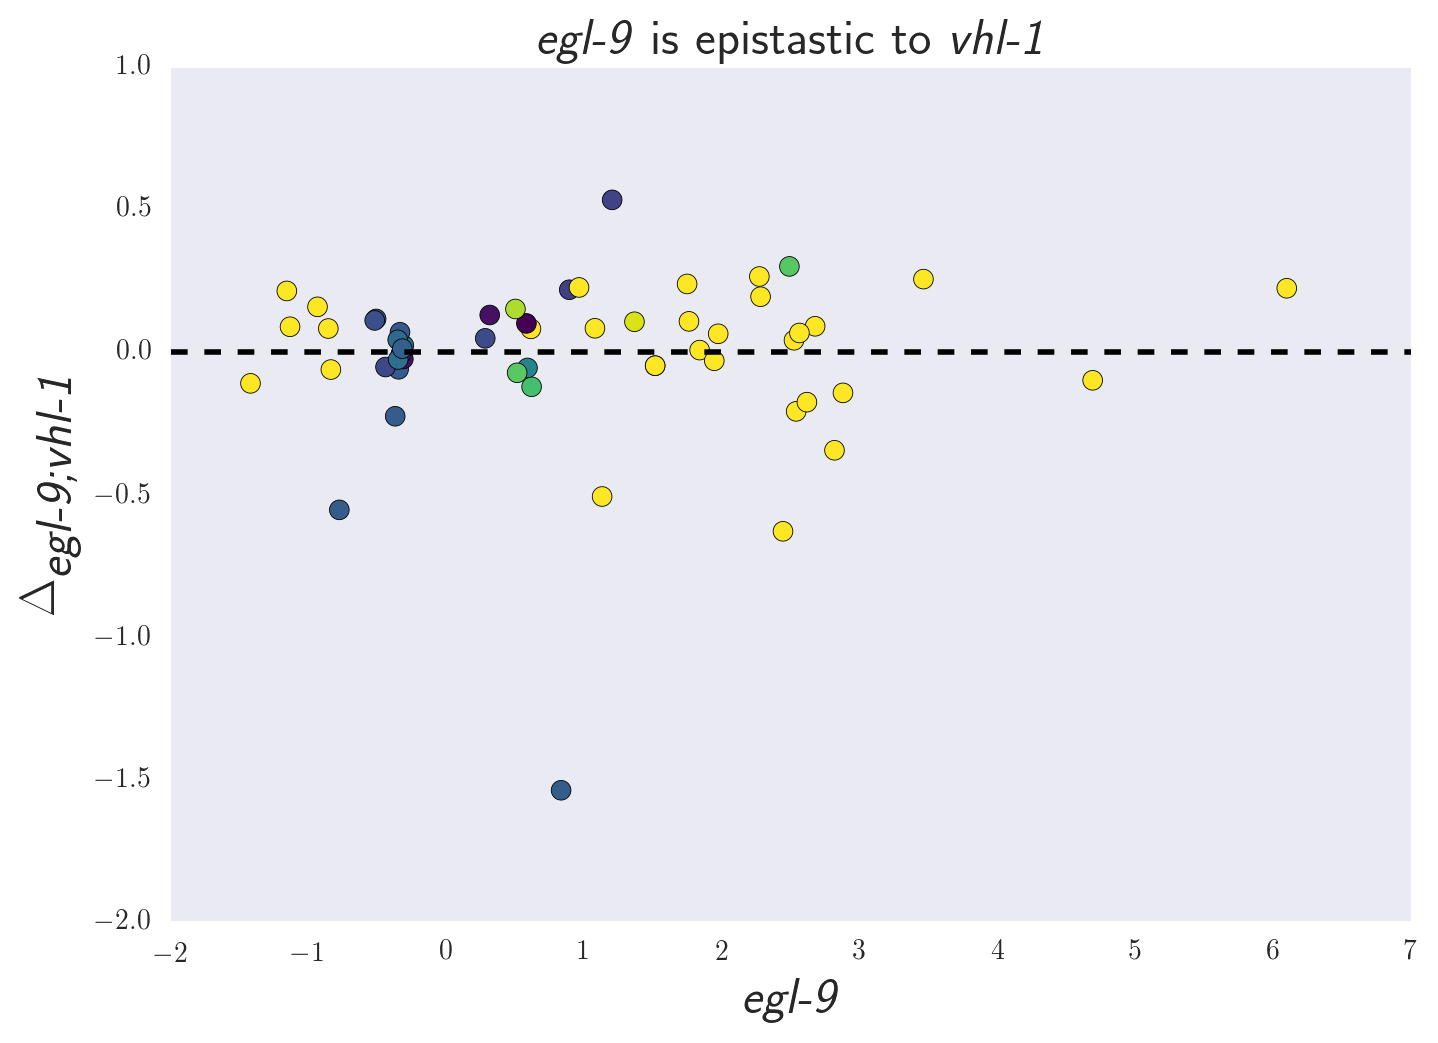

In [141]:
# matplotlib version of the same plot
def matplotlib_epistasis(x, y, qx, df):
    transformed_q = -df[qx].apply(np.log)
    transformed_q[transformed_q > 15] = 15
    cols = [
            "#%02x%02x%02x" % (int(r), 
            int(g), int(b)) for r, g, b, _ in
            255*mpl.cm.viridis(mpl.colors.Normalize()(
                           transformed_q))
            ]

    plt.scatter(df[x], df[y] - df[x], c=cols, s=50)

matplotlib_epistasis('b_b', 'b_a', 'q_b', y)
x= np.linspace(-2, 7)
plt.plot(x, np.zeros(len(x)), 'k--')
plt.xlabel(r'\emph{egl-9}')
plt.ylabel(r'\Delta_\emph{egl-9;vhl-1}')
plt.title(r'\emph{egl-9} is epistastic to \emph{vhl-1}')
plt.xlim(-2, 7)
plt.savefig('../output/egl9_epistatic_eglvhl.pdf')

In [21]:
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('egl_qval', '@q_b'),
            ('vhl_qval', '@q_d'),
            ('DM_qval', '@q_a')]

p = bokeh_plot_epistasis(y, 'b_d', 'b_a', 'q_d', 'q_a', 'se_b_d',
                         'se_b_a', tooltips, title='vhl-1 vs egl-9;vhl-1',
                        xlabel='vhl-1')
p.line([-10, 10], [0, 0], line_width=1, color='black')
# p.line([-10, 10], [-10*vhl_eglvhl, 10*vhl_eglvhl],
#        line_width=1, line_dash=(4, 4), color='red')

plot_significance(y, 'b_d', 'b_a', 'se_b_d', 'se_b_a', p)

html = file_html(p, CDN, "my plot")
HTML(html)

# # save to file
# with open('../output/vhl1_egl9vhl1_highconf.html', 'w') as f:
#     f.write(html)

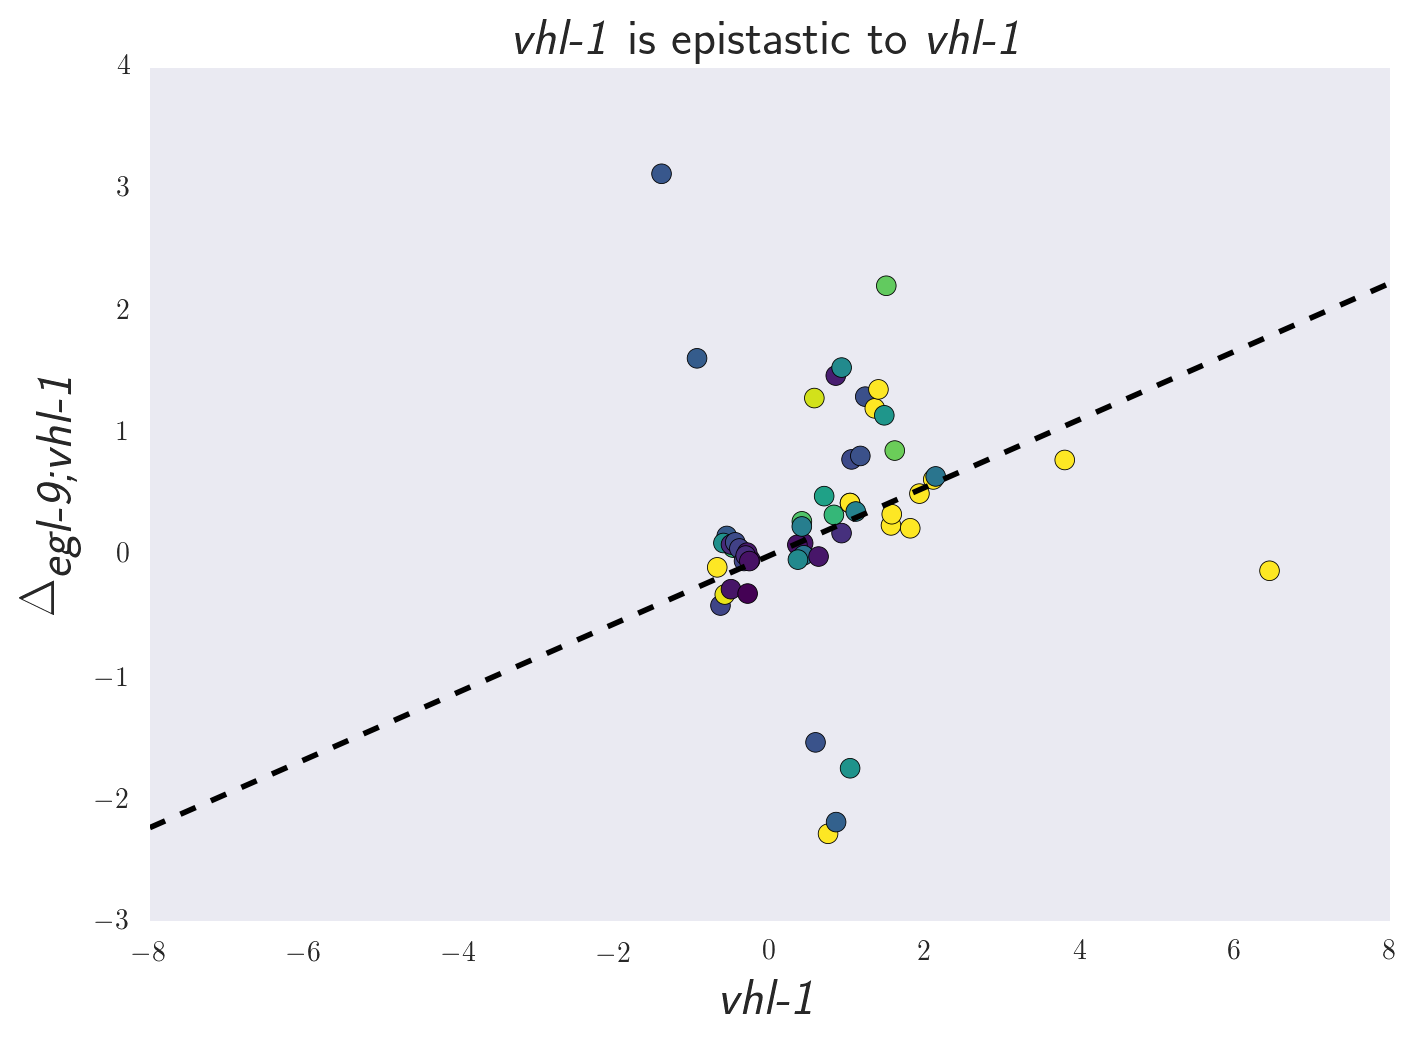

In [152]:
matplotlib_epistasis('b_d', 'b_a', 'q_d', y)
x = np.linspace(-8, 8)
z = x*vhl_eglvhl
plt.plot(x, z, 'k--')
plt.xlabel(r'\emph{vhl-1}')
plt.ylabel(r'\Delta_\emph{egl-9;vhl-1}')
plt.title(r'\emph{vhl-1} is epistastic to \emph{vhl-1}')
plt.xlim(-8, 8)
# plt.ylim(-3.5, 3.5)
plt.savefig('../output/vhl_epistatic_eglvhl.pdf')

In [18]:
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('egl_qval', '@q_b'),
            ('hif_qval', '@q_c'),
            ('DM_qval', '@qval')]

p = bokeh_plot_epistasis(y, 'b_b', 'b', 'q_b', 
                         'qval', 'se_b_b', 'se_b', 
                         tooltips, title='egl-9 vs egl-9;hif-1',
                         xlabel='egl-9')
p.line([-10, 10], [0, 0], line_width=1, color='black')
# p.line([-10, 10], [-10*egl_eglhif, 10*egl_eglhif],
#        line_width=1, line_dash=(4, 4), color='red')

plot_significance(y, 'b_b', 'b', 'se_b_b', 'se_b', p)

html = file_html(p, CDN, "my plot")
HTML(html)

# # save to file
# with open('../output/egl9_egl9hif1_highconf.html', 'w') as f:
#     f.write(html)
    

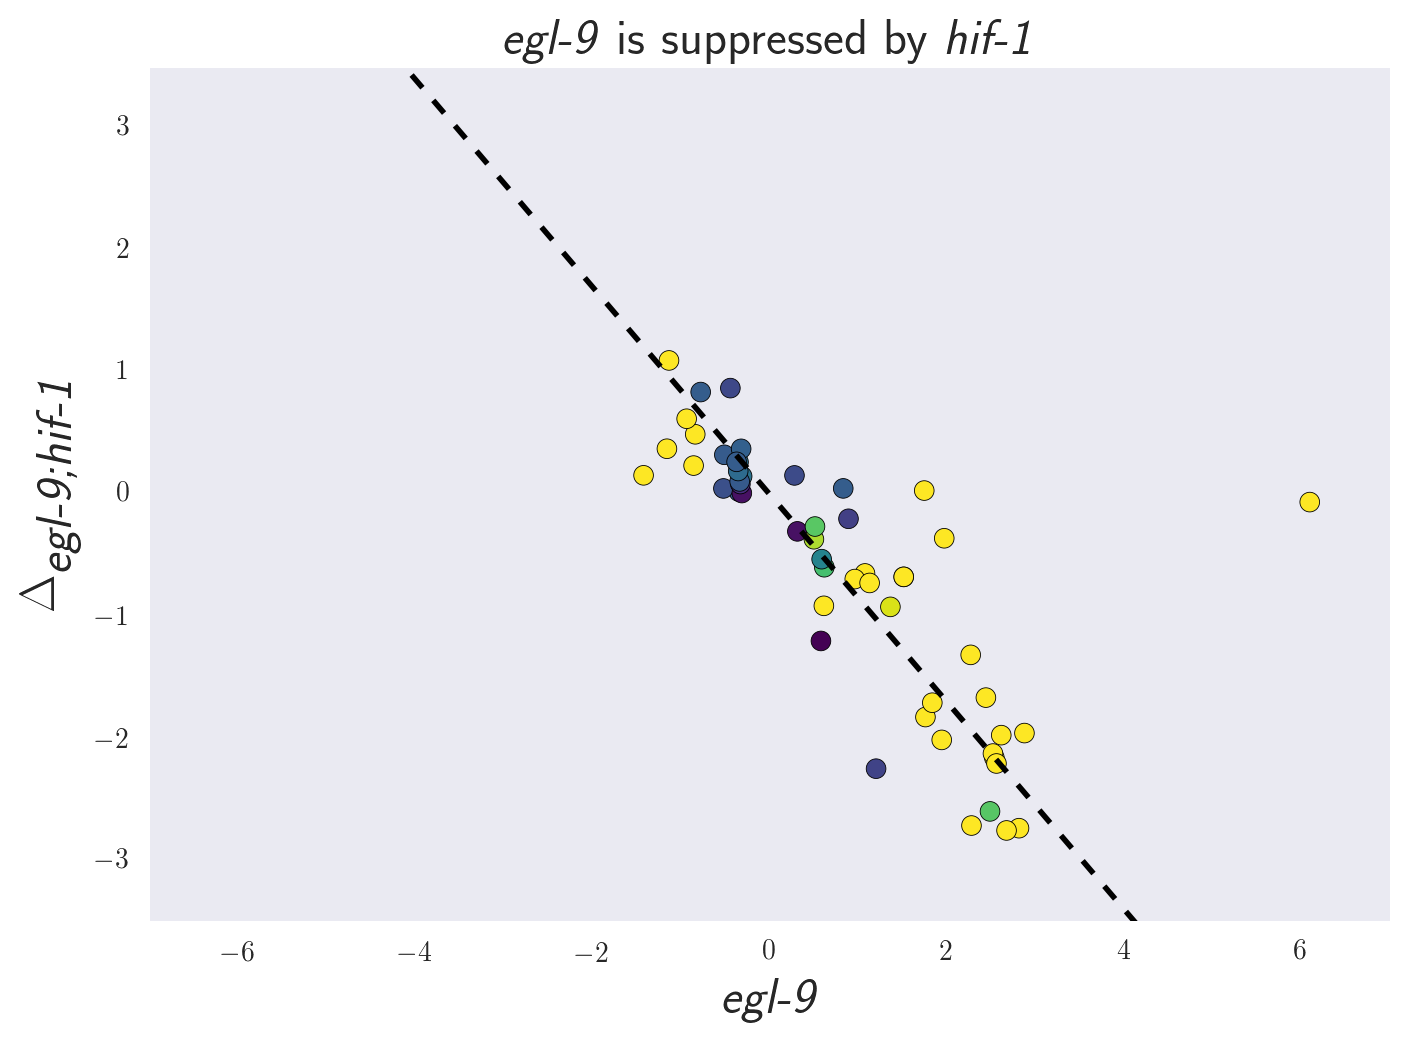

In [153]:
matplotlib_epistasis('b_b', 'b', 'q_b', y)
x = np.linspace(-5, 5)
z = x*egl_eglhif
plt.plot(x, z, 'k--')
plt.xlabel(r'\emph{egl-9}')
plt.ylabel(r'\Delta_\emph{egl-9;hif-1}')
plt.title(r'\emph{egl-9} is suppressed by \emph{hif-1}')
plt.xlim(-7, 7)
plt.ylim(-3.5, 3.5)
plt.savefig('../output/egl9_epistatic_eglhif.pdf')

In [19]:
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('egl_qval', '@q_b'),
            ('hif_qval', '@q_c'),
            ('DM_qval', '@qval')]

p = bokeh_plot_epistasis(y, 'b_c', 'b', 'q_c',
                         'qval', 'se_b_c', 'se_b',
                         tooltips, title='hif-1 vs egl-9;hif-1',
                         xlabel='hif-1')
p.line([-10, 10], [0, 0], line_width=1, color='black')

plot_significance(y, 'b_c', 'b', 'se_b_c', 'se_b', p)

html = file_html(p, CDN, "my plot")
HTML(html)

# # save to file
# with open('../output/hif1_egl9hif1_highconf.html', 'w') as f:
#     f.write(html)

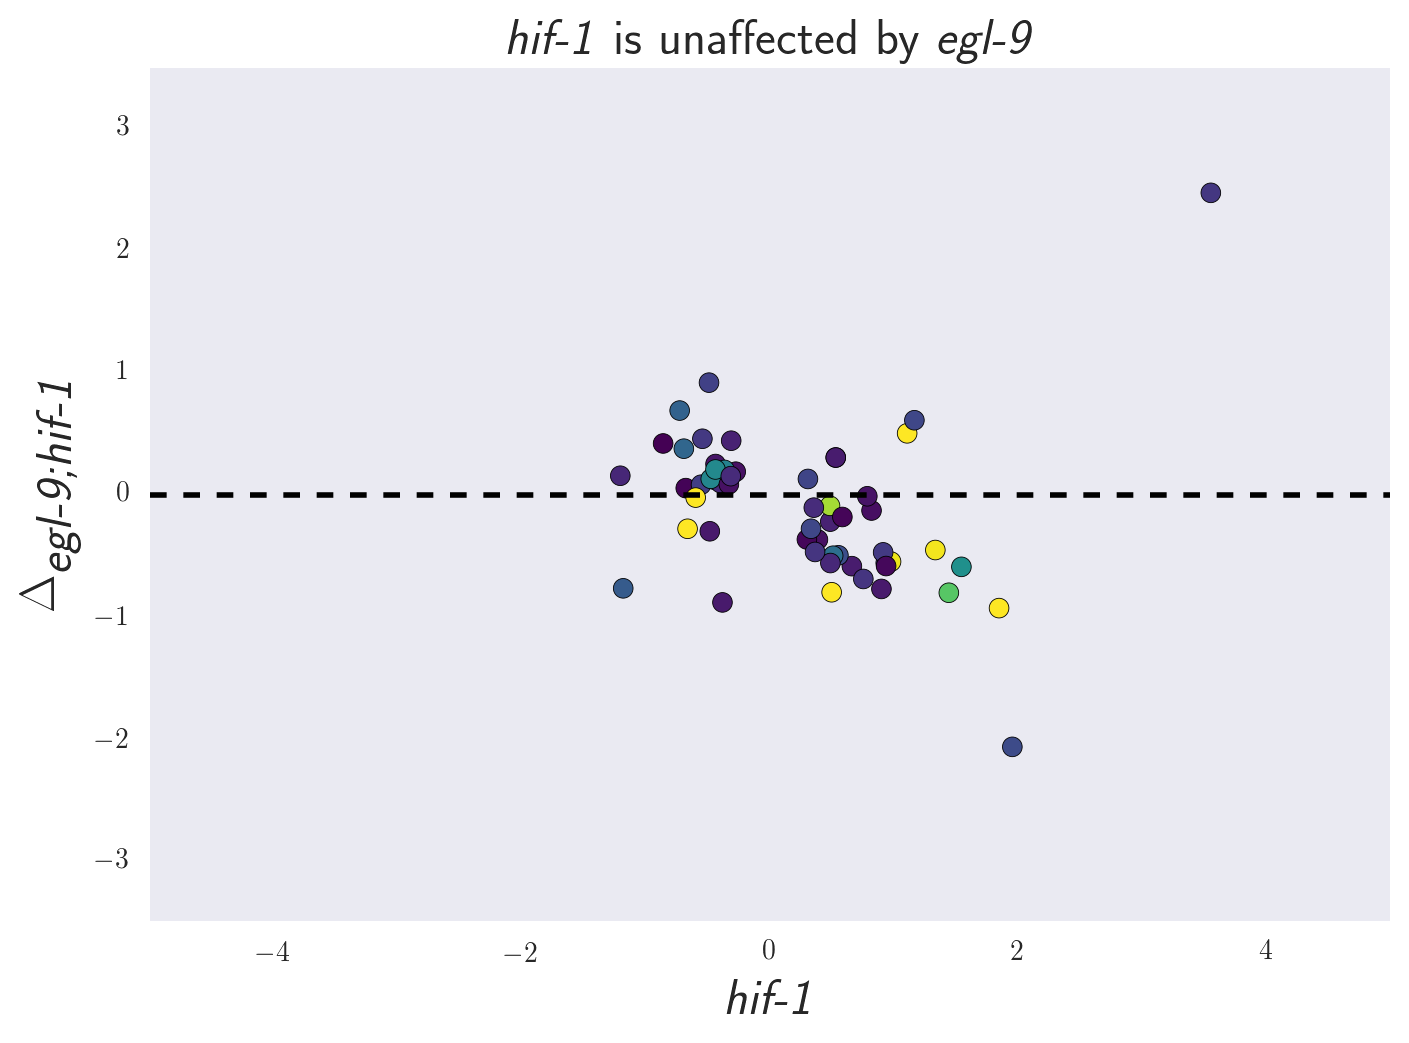

In [144]:
matplotlib_epistasis('b_c', 'b', 'q_c', y)
x = np.linspace(-5, 5)
z = x*hif_eglhif
plt.plot(x, np.zeros(len(x)), 'k--')
plt.xlabel(r'\emph{hif-1}')
plt.ylabel(r'\Delta_\emph{egl-9;hif-1}')
plt.title(r'\emph{hif-1} is unaffected by \emph{egl-9}')
plt.xlim(-5, 5)
plt.ylim(-3.5, 3.5)
plt.savefig('../output/hif1_epistatic_eglhif.pdf')

## Overlap between just two things

In [ ]:
overlap = sydney.overlap(thomas.beta['a'], thomas.beta['b'],
                         thomas)

# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('vhl_b', '@b_d'),
            ('egl_qval', '@q_b'),
            ('vhl_qval', '@q_d'),
            ('DM_qval', '@q_a')]

p = bokeh_plot_epistasis(temp, 'b_b', 'b_a', 'q_b', 'q_a', 'se_b_b',
                     'se_b_a', tooltips, title='egl9 vs egl9vhl1', 
                        xlabel='egl-9')
p.line([-10, 10], [0, 0], line_width=1, color='black')
p.line([-10, 10], [-10*egl_eglvhl, 10*egl_eglvhl],
       line_width=1, color='black', line_dash=(2, 2))
plot_significance(temp, 'b_b', 'b_a', 'se_b_b', 'se_b_a', p)

html = file_html(p, CDN, "my plot")
HTML(html)

# # save to file
# with open('../output/egl9_double.html', 'w') as f:
#     f.write(html)


In [ ]:
overlap = sydney.overlap(thomas.beta['a'], thomas.beta['d'],
                         thomas)
temp = df1[df1.target_id.isin(overlap)]

# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('egl_qval', '@q_b'),
            ('vhl_qval', '@q_d'),
            ('DM_qval', '@q_a')]

p = bokeh_plot_epistasis(temp, 'b_d', 'b_a', 'q_d',
                         'q_a', 'se_b_d', 'se_b_a',
                         tooltips, title='vhl1 vs egl9vhl1',
                         xlabel='vhl-1')
p.line([-10, 10], [0, 0], line_width=1, color='black')
p.line([-10, 10], [-10*vhl_eglvhl, 10*vhl_eglvhl],
       line_width=1, line_dash=(4, 4), color='red')

plot_significance(temp, 'b_d', 'b_a', 'se_b_d', 'se_b_a', p)


html = file_html(p, CDN, "my plot")
HTML(html)

In [ ]:
overlap = sydney.overlap(thomas.beta['f'], thomas.beta['b'],
                         thomas)
temp = df1[df1.target_id.isin(overlap)]

# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('egl_qval', '@q_b'),
            ('hif_qval', '@q_c'),
            ('DM_qval', '@q_a')]

p = bokeh_plot_epistasis(temp, 'b_b', 'b', 'q_b', 'qval', 
                         'se_b_b', 'se_b', tooltips, 
                         title='egl9 vs egl9hif1', xlabel='egl9')
p.line([-10, 10], [0, 0], line_width=1, color='black')
p.line([-10, 10], [-10*egl_eglhif, 10*egl_eglhif], 
       line_width=1, color='black', line_dash=(2, 2))

plot_significance(temp, 'b_b', 'b', 'se_b_b', 'se_b', p)


html = file_html(p, CDN, "my plot")
HTML(html)

In [ ]:
overlap = sydney.overlap(thomas.beta['f'], thomas.beta['c'],
                         thomas)
temp = df1[df1.target_id.isin(overlap)]

# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('egl_qval', '@q_b'),
            ('hif_qval', '@q_c'),
            ('DM_qval', '@qval')]

p = bokeh_plot_epistasis(temp, 'b_c', 'b', 'q_c', 'qval', 
                         'se_b_c', 'se_b', tooltips,
                         title='hif1 vs egl9hif1', xlabel='hif-1')

p.line([-10, 10], [0, 0], line_width=1, color='black')

plot_significance(temp, 'b_c', 'b', 'se_b_c', 'se_b', p)

html = file_html(p, CDN, "my plot")
HTML(html)

## Identifying all genes associated with the hypoxia response

In [ ]:
for key, df in thomas.beta.items():
    thomas.beta[key]['genotype'] = key
frame = [thomas.beta[key] for key in thomas.beta.keys()]

In [ ]:
tidy_df = pd.concat(frame)

In [ ]:
ind = (tidy_df.qval < 0.1) & (tidy_df.genotype != 'g')
tidy_df[ind].ens_gene.unique().shape

In [ ]:
ids = tidy_df[ind].ens_gene.unique()
_ = tea.enrichment_analysis(ids,
                            tissue_df, show=True)
_ = tea.enrichment_analysis(ids,
                            phenotype_df, show=False)
print(_[0].head())
_ = tea.enrichment_analysis(ids,
                            go_df, show=False)
_[0].head(15)

# Single Mutant Comparison Interactive Plots

In [ ]:
def bokeh_plot_expression(df, gx, gy, qx, qy, se_gx,
                          se_gy, tooltips, title,
                          xlabel, ylabel):
    """A function to plot the bokeh single mutant comparisons."""
    # Make the hover tool
    hover = bokeh.models.HoverTool(tooltips=tooltips,
                                   names=['circles'])

    # Create figure
    p = bokeh.plotting.figure(title=title, plot_width=650, 
                              plot_height=450)

    p.xgrid.grid_line_color = 'white'
    p.ygrid.grid_line_color = 'white'
    p.xaxis.axis_label = xlabel
    p.yaxis.axis_label = ylabel

    # Add the hover tool
    p.add_tools(hover)

    # Define colors in a dictionary to access them with
    # the key from the pandas groupby funciton.
    source1 = bokeh.models.ColumnDataSource(df)

    transformed_q = np.sqrt(-df[qx].apply(np.log))
    transformed_q[transformed_q > 15] = 15
    cols = [
        "#%02x%02x%02x" % (int(r), 
        int(g), int(b)) for r, g, b, _ in
        255*mpl.cm.viridis(mpl.colors.Normalize()(
                           transformed_q))
            ]

    # Specify data source
    p.circle(x=gx, y=gy, size=7,
             alpha=0.4, source=source1,
             color=cols, name='circles')
    p.circle(x=gx, y=gy, size=7,
             alpha=1, fill_color=None,
             color='black', source=source1)
    
    def bokeh_errorbars():
        """A function to plot errorbars."""
        def zipper(which='x'):
            err_xs = []
            err_ys = []
            if which == 'x':
                for x, z, xerr in zip(df[gx],
                                      df[gy],
                                      df[se_gx]):
                    err_xs.append((x - xerr, x + xerr))
                    err_ys.append((z, z))
            else:

                yerr = df[se_gy]
                for x, y, yerror in zip(df[gx],
                                     df[gy],
                                     yerr):
                    err_xs.append((x, x))
                    y_tuple = (y - yerror, y + yerror)
                    err_ys.append(y_tuple)

            return err_xs, err_ys
        
        errx_xs, errx_ys = zipper('x')
        erry_xs, erry_ys = zipper('y')
        
        return errx_xs, errx_ys, erry_xs, erry_ys
    
    # make the errorbars
    errx_xs, errx_ys, erry_xs, erry_ys = bokeh_errorbars()
    # plot them
    p.multi_line(errx_xs, errx_ys, color=cols, alpha=0.4)
    p.multi_line(erry_xs, erry_ys, color=cols, alpha=0.4)
    
    # prettify
    p.background_fill_color = "#DFDFE5"
    p.background_fill_alpha = 0.5
    
    return p

In [ ]:
overlap = sydney.overlap(thomas.beta['c'], thomas.beta['b'],
                         thomas)
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('egl_qval', '@q_b'),
            ('hif_qval', '@q_c'),
           ]

ind = df1.target_id.isin(overlap)
p = bokeh_plot_expression(df1[ind], 'b_c', 'b_b', 
                      'q_c', 'q_b', 'se_b_c', 'se_b_b',
                      tooltips, title='hif1 vs egl9',
                      xlabel='hif-1', ylabel='egl-9')

p.line([-10, 10], [-10, 10], line_width=1, color='black')
p.line([-10, 10], [10, -10], line_width=1, color='black')


html = file_html(p, CDN, "my plot")
HTML(html)

In [ ]:
overlap = sydney.overlap(thomas.beta['c'], thomas.beta['e'],
                         thomas)
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('rhy_qval', '@q_e'),
            ('hif_qval', '@q_c'),
           ]

ind = df1.target_id.isin(overlap)
p = bokeh_plot_expression(df1[ind], 'b_c', 'b_e', 
                      'q_c', 'q_e', 'se_b_c', 'se_b_e',
                      tooltips, title='rhy-1 vs hif-1',
                      xlabel='hif-1', ylabel='rhy-1')

p.line([-10, 10], [-10, 10], line_width=1, color='black')
p.line([-10, 10], [10, -10], line_width=1, color='black')


html = file_html(p, CDN, "my plot")
HTML(html)

In [ ]:
overlap = sydney.overlap(thomas.beta['c'], thomas.beta['d'],
                         thomas)
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('vhl_qval', '@q_d'),
            ('hif_qval', '@q_c'),
           ]

ind = df1.target_id.isin(overlap)
p = bokeh_plot_expression(df1[ind], 'b_c', 'b_d', 
                      'q_c', 'q_d', 'se_b_c', 'se_b_d', tooltips,
                      title='vhl-1 vs hif-1', xlabel='hif-1',
                      ylabel='vhl-1')

p.line([-10, 10], [-10, 10], line_width=1, color='black')
p.line([-10, 10], [10, -10], line_width=1, color='black')


html = file_html(p, CDN, "my plot")
HTML(html)

In [ ]:
overlap = sydney.overlap(thomas.beta['b'], thomas.beta['d'],
                         thomas)
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('vhl_qval', '@q_d'),
            ('egl_qval', '@q_b'),
           ]

ind = df1.target_id.isin(overlap)
p = bokeh_plot_expression(df1[ind], 'b_b', 'b_d', 
                      'q_b', 'q_d', 'se_b_b', 'se_b_d',
                      tooltips, title='egl-9 vs vhl-1',
                      xlabel='egl-9', ylabel='vhl-1')

p.line([-10, 10], [-10, 10], line_width=1, color='black')
p.line([-10, 10], [10, -10], line_width=1, color='black')


html = file_html(p, CDN, "my plot")
HTML(html)

In [ ]:
overlap = sydney.overlap(thomas.beta['e'], thomas.beta['d'],
                         thomas)
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('vhl_qval', '@q_d'),
            ('rhy_qval', '@q_e'),
           ]

ind = df1.target_id.isin(overlap)
p = bokeh_plot_expression(df1[ind], 'b_e', 'b_d', 
                      'q_e', 'q_d', 'se_b_e', 'se_b_d',
                      tooltips, title='rhy-1 vs vhl-1',
                          xlabel='rhy-1', ylabel='vhl-1')

p.line([-10, 10], [-10, 10], line_width=1, color='black')
p.line([-10, 10], [10, -10], line_width=1, color='black')


html = file_html(p, CDN, "my plot")
HTML(html)

In [ ]:
overlap = sydney.overlap(thomas.beta['e'], thomas.beta['b'],
                         thomas)
# What pops up on hover?
tooltips = [('ext_gene', '@ext_gene'),
            ('vhl_qval', '@q_d'),
            ('rhy_qval', '@q_e'),
           ]

ind = df1.target_id.isin(overlap)
p = bokeh_plot_expression(df1[ind], 'b_e', 'b_b', 
                      'q_e', 'q_b', 'se_b_e', 'se_b_b',
                      tooltips, title='rhy-1 vs egl-9',
                          xlabel='rhy-1', ylabel='egl-9')

p.line([-10, 10], [-10, 10], line_width=1, color='black')
p.line([-10, 10], [10, -10], line_width=1, color='black')


html = file_html(p, CDN, "my plot")
HTML(html)

In [ ]:
y[y.ext_gene == 'nog-1'].ens_gene

In [132]:
for name, group in thomas.genmap.groupby('genotype'):
    print(name)
    for p1 in group.project_name:
        for p2 in group.project_name:
            s = sts.spearmanr(thomas.tpm[p1].tpm, thomas.tpm[p2].tpm)
            print('{0}, {1}, {2:2g}'.format(p1, p2, s[0]))

a
Project_17441_indexN704-N508, Project_17441_indexN704-N508,  1
Project_17441_indexN704-N508, Project_17442_indexN705-N517, 0.912686
Project_17441_indexN704-N508, Project_17440_indexN704-N507, 0.909556
Project_17442_indexN705-N517, Project_17441_indexN704-N508, 0.912686
Project_17442_indexN705-N517, Project_17442_indexN705-N517,  1
Project_17442_indexN705-N517, Project_17440_indexN704-N507, 0.909838
Project_17440_indexN704-N507, Project_17441_indexN704-N508, 0.909556
Project_17440_indexN704-N507, Project_17442_indexN705-N517, 0.909838
Project_17440_indexN704-N507, Project_17440_indexN704-N507,  1
b
Project_17437_indexN704-N504, Project_17437_indexN704-N504,  1
Project_17437_indexN704-N504, Project_17438_indexN704-N505, 0.90638
Project_17437_indexN704-N504, Project_17439_indexN704-N506, 0.90886
Project_17438_indexN704-N505, Project_17437_indexN704-N504, 0.90638
Project_17438_indexN704-N505, Project_17438_indexN704-N505,  1
Project_17438_indexN704-N505, Project_17439_indexN704-N506, 0.9